In [1]:
#!pip install sparse-transform==0.1
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from accelerate import Accelerator
# import spectralexplain as spex
import numpy as np
import time
import functools
import importlib.metadata
import shapiq
import pandas as pd
import ast

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df=pd.read_csv("../data/complementary.csv")
df.context=df.context.apply(ast.literal_eval)

In [ ]:
df.question[9]

In [ ]:
df.context[0]

In [ ]:
context = [
    "The weather in Chorvoq is sunny today.",
    "Berlin is the capital of Germany.", # Irrelevant
    "The Eiffel Tower is located in Paris, France.",
    "France borders several countries including Germany.",
    "The currency used in Suvsambil is the chaqa.",
    "Chorvoq is the capital of Suvsambil.",
    "Paris hosted the Summer Olympics in 1900 and 1924.",
    "Germany uses the Euro as well.", # Redundant info
    "The sun is shining in Chorvoq today",
    "It is cloudy in Berlin today."
    ]
question="what is the weather like in the capital of Suvsambil"
# context=['Stuart Rosenberg (August 11, 1927 – March 15, 2007) was an American film and television director whose motion pictures include "Cool Hand Luke" (1967), "Voyage of the Damned" (1976), "The Amityville Horror" (1979), and "The Pope of Greenwich Village" (1984). He was noted for his work with actor Paul Newman.',
#  'Méditerranée is a 1963 French experimental film directed by Jean-Daniel Pollet with assistance from Volker Schlöndorff. It was written by Philippe Sollers and produced by Barbet Schroeder, with music by Antione Duhamel. The 45 minute film is cited as one of Pollet\'s most influential films, which according to Jonathan Rosenbaum directly influenced Jean-Luc Goddard\'s "Contempt", released later the same year. Footage for the film was shot around the Mediterranean, including at a Greek temple, a Sicilian garden, the sea, and also features a fisherman, a bullfighter, and a girl on an operating table.',
#  'Move is a 1970 American comedy film starring Elliott Gould, Paula Prentiss and Geneviève Waïte, and directed by Stuart Rosenberg. The screenplay was written by Joel Lieber and Stanley Hart, adapted from a novel by Lieber.',
#  'Ian Barry is an Australian director of film and TV.',
#  'Peter Levin is an American director of film, television and theatre.',
#  'Brian Johnson( born 1939 or 1940) is a British designer and director of film and television special effects.',
#  'Rachel Feldman( born August 22, 1954) is an American director of film and television and screenwriter of television films.',
#  'Hanro Smitsman, born in 1967 in Breda( Netherlands), is a writer and director of film and television.',
#  'Jean-Daniel Pollet (1936–2004) was a French film director and screenwriter who was most active in the 1960s and 1970s. He was associated with two approaches to filmmaking: comedies which blended burlesque and melancholic elements, and poetic films based on texts by writers such as the French poet Francis Ponge.',
#  'Howard Winchel Koch( April 11, 1916 – February 16, 2001) was an American producer and director of film and television.']
# question = ['Are director of film Move (1970 Film) and director of film Méditerranée (1963 Film) from the same country?']

In [2]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
model_path = "mistralai/Mistral-7B-Instruct-v0.3"
# model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [ ]:
question='Who directed Echoes of Solaris and who directed Storms of Aether?'
# question='Did Echoes of Solaris and Storms of Aether have the same director?'
context=["The film *Echoes of Solaris* was directed by Mara Veyla.",
 "Some starships patrol the Outer Rim.",
 "Lira Soren graduated from the Celestial Naval Academy.",
 "At the beginning Kael Draven was a decorated war strategist.",
 "Aurora's Wake specializes in reconnaissance missions.",
 "Iron Tempest often leads frontline engagements.",
 "The starship *Aurora's Wake* is captained by Lira Soren.",
 "The Admiralty often compares their leadership styles.",
 "Both captains have commanding roles during interstellar peace talks.",
 "The film *Storms of Aether* was directed by Jorin Tal."
 ]

In [9]:
# question="Do Aurora’s Wake and Iron Tempest have the same captain?"
question="Who commands the starship Aurora’s Wake and who commands the Iron Tempest?"
context=["The starship *Aurora's Wake* is captained by Lira Soren."
 "Some starships patrol the Outer Rim.",
 "Lira Soren graduated from the Celestial Naval Academy.",
 "At the beginning Kael Draven was a decorated war strategist.",
 "Aurora's Wake specializes in reconnaissance missions.",
 "Iron Tempest often leads frontline engagements.",
 "Fleet records show both captains have served for over a decade.",
 "The Admiralty often compares their leadership styles.",
 "Both captains have commanding roles during interstellar peace talks.",
  "The starship *Iron Tempest* is captained by Kael Draven.",]


In [ ]:
utility_cache_base_dir = f"../Experiment_data/musique/{model_path.split('/')[1]}/four/"
utility_cache_filename = f"utilities_q_idx19853.pkl"
current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

In [10]:
harness = ContextAttribution(
    items=context,
    query=question,
    prepared_model=prepared_model,
    prepared_tokenizer=tokenizer,
    accelerator=accelerator_main,
    utility_mode='log-perplexity',
    utility_cache_path= None
)

In [16]:
harness.target_response

"Lira Soren commands the starship Aurora's Wake, and Kael Draven commands the starship Iron Tempest."

In [17]:
attributionban, interactionban, intr = harness.compute_shapiq_fsii(budget=128)

In [ ]:
print(interactionban)
print(attributionban)

In [11]:
methods_results, extra_results, fm_models = harness.compute_wss(
                    num_samples=128,
                    seed=SEED,
                    sampling="kernelshap",
                    rank=2,
                    sur_type="fm")

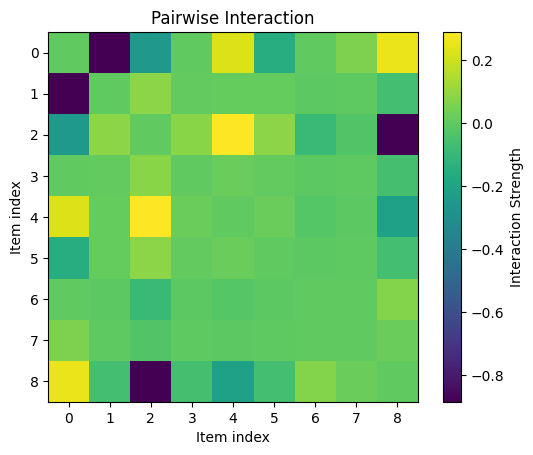

In [23]:
plt.imshow(extra_results, cmap="viridis")  # you can change 'viridis' to any colormap
plt.colorbar(label="Interaction Strength")
plt.xticks(range(len(extra_results)), range(len(extra_results)))
plt.yticks(range(len(extra_results)), range(len(extra_results)))
plt.xlabel("Item index")
plt.ylabel("Item index")
plt.title("Pairwise Interaction")
plt.show()

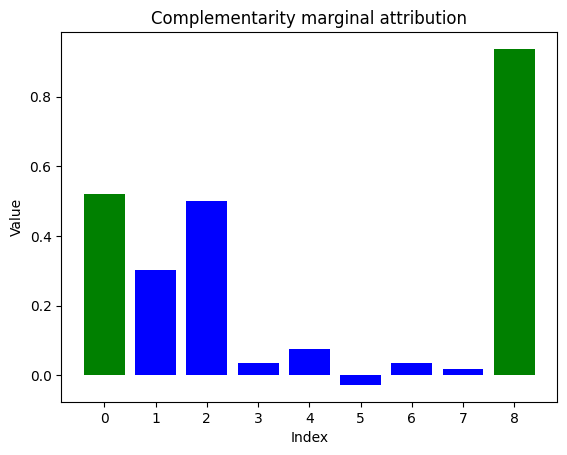

In [7]:
import matplotlib.pyplot as plt
import numpy as np
colors = ['blue'] * len(methods_results)

# Change first two
colors[0] = 'green'
colors[-1] = 'green'
plt.bar(range(methods_results.shape[0]), methods_results, color=colors)
plt.xticks(range(methods_results.shape[0]), range(methods_results.shape[0]))
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Complementarity marginal attribution")
plt.show()

In [ ]:
class CallCounter:
    """Wrapper to count function calls."""
    def __init__(self, func):
        functools.update_wrapper(self, func)
        self.func = func
        self.count = 0

    def __call__(self, *args, **kwargs):
        self.count += 1
        return self.func(*args, **kwargs)
        
valuef_counter = CallCounter(harness._compute_response_metric)

def value_function(X):
    out_values = list()
    for x in X:
        selected_indexes = (np.asarray(x) == 1).nonzero()[0]
        ablated_context = np.array(df.context[1])[selected_indexes]
        ablated_context_str = ' '.join(ablated_context.tolist())
        out_values.append(valuef_counter(ablated_context_str, mode="log-perplexity"))
    return np.array(out_values)

In [ ]:
approximator = shapiq.ProxySPEX(n=harness.n_items, index='FSII', max_order=harness.n_items)

In [ ]:
moebius_interactions = approximator.approximate(budget=264, game=value_function)

In [ ]:
moebius_interactions.dict_values

In [ ]:
from shapiq import SHAPIQ
approximator = SHAPIQ(harness.n_items, min_order=0, max_order=2, index="FSII", top_order=False,random_state=SEED)

In [ ]:
moebius_interactions=approximator(budget=200, game=value_function)

In [ ]:
explainer = SHAPIQ(n=harness.n_items, index='FSII', max_order=1, random_state=42)
main_effects=explainer(game=harness._make_value_function('log-perplexity'), budget=200).dict_values

explainer2 = SHAPIQ(n=harness.n_items, index='FSII', max_order=2, random_state=42)
interaction_terms=explainer2(game=harness._make_value_function('log-perplexity'), budget=200).dict_values
interaction_values = interaction_terms|main_effects

In [ ]:
interaction_terms

In [ ]:
moebius_interactions.dict_values

In [ ]:
approximator1=shapiq.explainer.agnostic.AgnosticExplainer(game=value_function, n_players=harness.n_items, index='FSII', max_order=1, approximator='montecarlo', random_state=42)

In [ ]:
interactions=approximator1.explain_function(200)

In [ ]:
spr, _=spearmanr(list(interactions.dict_values.values()), list(moebius_interactions.dict_values.values()))

In [ ]:
spr

In [ ]:
np.array(list(moebius_interactions.dict_values.values()))

In [ ]:
# Generate test masking patterns (binary vectors)
n_test_maskings_patterns = 20
X_test_maskings = np.random.randint(0, 2, size=(n_test_maskings_patterns, harness.n_items))

# Evaluate the true scores for test masks using the scalarizer
y_test = value_function(X_test_maskings)
# Using the Moebius interactions, finds the approximations computed by SPEX
y_pred = np.zeros(n_test_maskings_patterns)
for i, x in enumerate(X_test_maskings):
  for loc, coef in moebius_interactions.dict_values.items():
    # print(loc)
    if all(x[l] == 1 for l in loc):
      y_pred[i] += coef

In [ ]:
y_test

In [ ]:
y_pred

In [ ]:
attribution = np.zeros(10)
interaction_terms = {}
for pattern, coef in interaction_values.dict_values.items():
    order = len(pattern)
    if order == 1:
        attribution[pattern] = coef
    elif order == 2:
        interaction_terms[pattern] = coef

In [ ]:
interaction_terms

In [ ]:
n_sources = len(context)
n_maskings_patterns = 
n_test_maskings_patterns = 30
approximator = shapiq.approximator.sparse.spex.SPEX(n=n_sources, index="FSII", max_order=harness.n_items)

In [ ]:
n_sources

In [ ]:
value_function(X_test_maskings)

In [ ]:
moebius_interactions.dict_values.items()

In [ ]:
attribution = np.zeros(harness.n_items)
interaction_terms = {}
print("Extracting attributions and interactions from SPEX results...")
for pattern, coef in moebius_interactions.dict_values.items():
    order = len(pattern)
    if order == 1:
        attribution[pattern] = coef
    elif order ==2:
        interaction_terms[pattern] = coef
    else:
        continue

In [ ]:
moebius_interactions.dict_values[(2,3,4,7)]

In [ ]:
# Generate test masking patterns (binary vectors)
X_test_maskings = np.random.randint(0, 2, size=(n_test_maskings_patterns, n_sources))

# Evaluate the true scores for test masks using the scalarizer
y_test = value_function(X_test_maskings)
# Using the Moebius interactions, finds the approximations computed by SPEX
y_pred = np.zeros(n_test_maskings_patterns)
for i, x in enumerate(X_test_maskings):
  for loc, coef in moebius_interactions.dict_values.items():
    # print(loc)
    if all(x[l] == 1 for l in loc):
      y_pred[i] += coef

# Compute R² (coefficient of determination) to evaluate approximation quality
# r2 = 1 - (np.linalg.norm(y_test - y_pred) ** 2 / np.linalg.norm(y_test - np.mean(y_test)) ** 2)
# print(f'The r2 for this example is : {r2}')

In [ ]:
X_test_maskings

In [ ]:
y_pred

In [ ]:
attribution = np.zeros(harness.n_items)
interaction_terms = {}

for pattern, coef in moebius_interactions.dict_values.items():
    order = len(pattern)
    if order == 1:
        attribution[pattern] = coef
    elif order == 2:
        interaction_terms[pattern] = coef

In [ ]:
interaction_terms

In [ ]:
import random
random.seed(42)
explainer = spex.Explainer(
    value_function=value_function,
    features=context,
    sample_budget = 1104,
    max_order=10
)

In [ ]:
method_interactions = explainer.interactions(index='fbii')
converted = method_interactions.convert_fourier_interactions()

attribution = np.zeros(len(context))
interaction_terms = {}

for pattern, coef in converted.items():
    order = sum(pattern)
    if order == 1:
        idx = pattern.index(1)
        attribution[idx] = abs(coef)
    elif order == 2:
        interaction_terms[pattern] = coef

In [ ]:
# Using the Moebius interactions, finds the approximations computed by SPEX
y_pred = np.zeros(n_test_maskings_patterns)
for i, x in enumerate(X_test_maskings):
  for loc, coef in converted.items():
    # print(f"{loc} and -> {coef} compared to {y_test[i]}")
    if all(x[l] == 1 for l in loc):
      y_pred[i] += coef

# Compute R² (coefficient of determination) to evaluate approximation quality
r2 = 1 - (np.linalg.norm(y_test - y_pred) ** 2 / np.linalg.norm(y_test - np.mean(y_test)) ** 2)
print(f'The r2 for this example is : {r2}')

In [ ]:
# interactionsb = explainer.interactions(index="fbii")
# interactionss = explainer.interactions(index="fsii")
# interactionsm = explainer.interactions(index="mobius")
# interactionsf = explainer.interactions(index="fourier")

# print(interactionsb)
# print(interactionss)
# print(interactionsm)
# print(interactionsf)

In [ ]:
interactionss.convert_fourier_interactions()

In [ ]:
interactions = explainer.interactions(index="fsii")
print(interactions)

In [ ]:
interactionss.convert_fourier_interactions()

In [ ]:
interactions.items()